# Import packages and load data

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scanpy.external as sce
import seaborn as sbn
import matplotlib as mpl
import matplotlib.pyplot as plt
import gseapy
import scvelo as scv
import louvain

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, dpi_save=300, facecolor='white', format='tif')

scanpy==1.8.2 anndata==0.7.8 umap==0.5.3 numpy==1.22.4 scipy==1.8.1 pandas==1.4.3 scikit-learn==1.1.1 statsmodels==0.13.2 python-igraph==0.7.1 louvain==0.8.0 leidenalg==0.8.3 pynndescent==0.5.7


In [3]:
adata = sc.read('G-P28_raw_matrix.h5ad')

In [4]:
adata

AnnData object with n_obs × n_vars = 18796 × 31053
    var: 'gene_ids', 'feature_types', 'genome'

# Subset Epithelial cells (Epi)

In [6]:
Epi_barcodes = sc.read_csv(r"Epi_barcodes_GingivaP28.csv", delimiter = None, first_column_names=None)

In [7]:
Epi_barcodes 

AnnData object with n_obs × n_vars = 1140 × 0

In [8]:
Epi_GP28 = adata[Epi_barcodes.obs_names]

In [9]:
Epi_GP28

View of AnnData object with n_obs × n_vars = 1140 × 31053
    var: 'gene_ids', 'feature_types', 'genome'

# Preprocessing

normalizing counts per cell
    finished (0:00:00)


/home/diisakura/miniconda3/envs/oralfbs/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


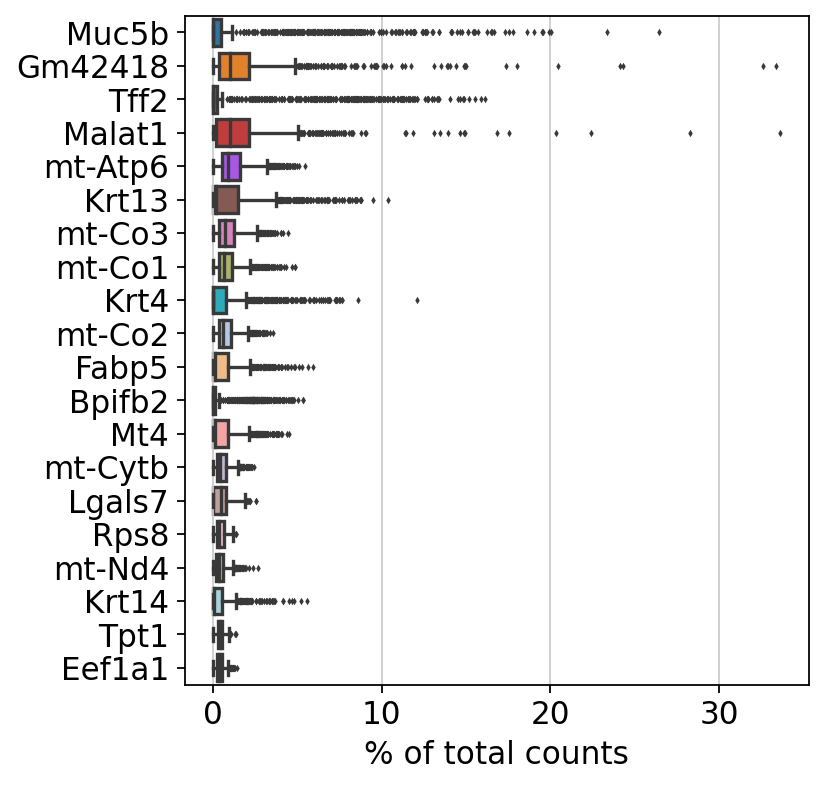

In [10]:
sc.pl.highest_expr_genes(Epi_GP28, n_top=20, )

In [19]:
sc.pp.filter_cells(Epi_GP28, min_genes=200)
sc.pp.filter_genes(Epi_GP28, min_cells=3)
sc.pp.filter_cells(Epi_GP28, min_counts = 100)
sc.pp.filter_genes(Epi_GP28, min_counts = 10)

filtered out 15680 genes that are detected in less than 3 cells
filtered out 1917 genes that are detected in less than 10 counts


In [20]:
Epi_GP28.var['mito'] = Epi_GP28.var_names.str.startswith('mt-')
Epi_GP28.var['hemo'] = Epi_GP28.var_names.str.startswith('Hba') | Epi_GP28.var_names.str.startswith('Hbb')
Epi_GP28.var['ribo'] = Epi_GP28.var_names.str.startswith('Rps') | Epi_GP28.var_names.str.startswith('Rpl')
sc.pp.calculate_qc_metrics(Epi_GP28, qc_vars=['mito', 'hemo', 'ribo'], percent_top=None, log1p=False, inplace=True)

/home/diisakura/miniconda3/envs/oralfbs/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'feature_types' as categorical
/home/diisakura/miniconda3/envs/oralfbs/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'genome' as categorical


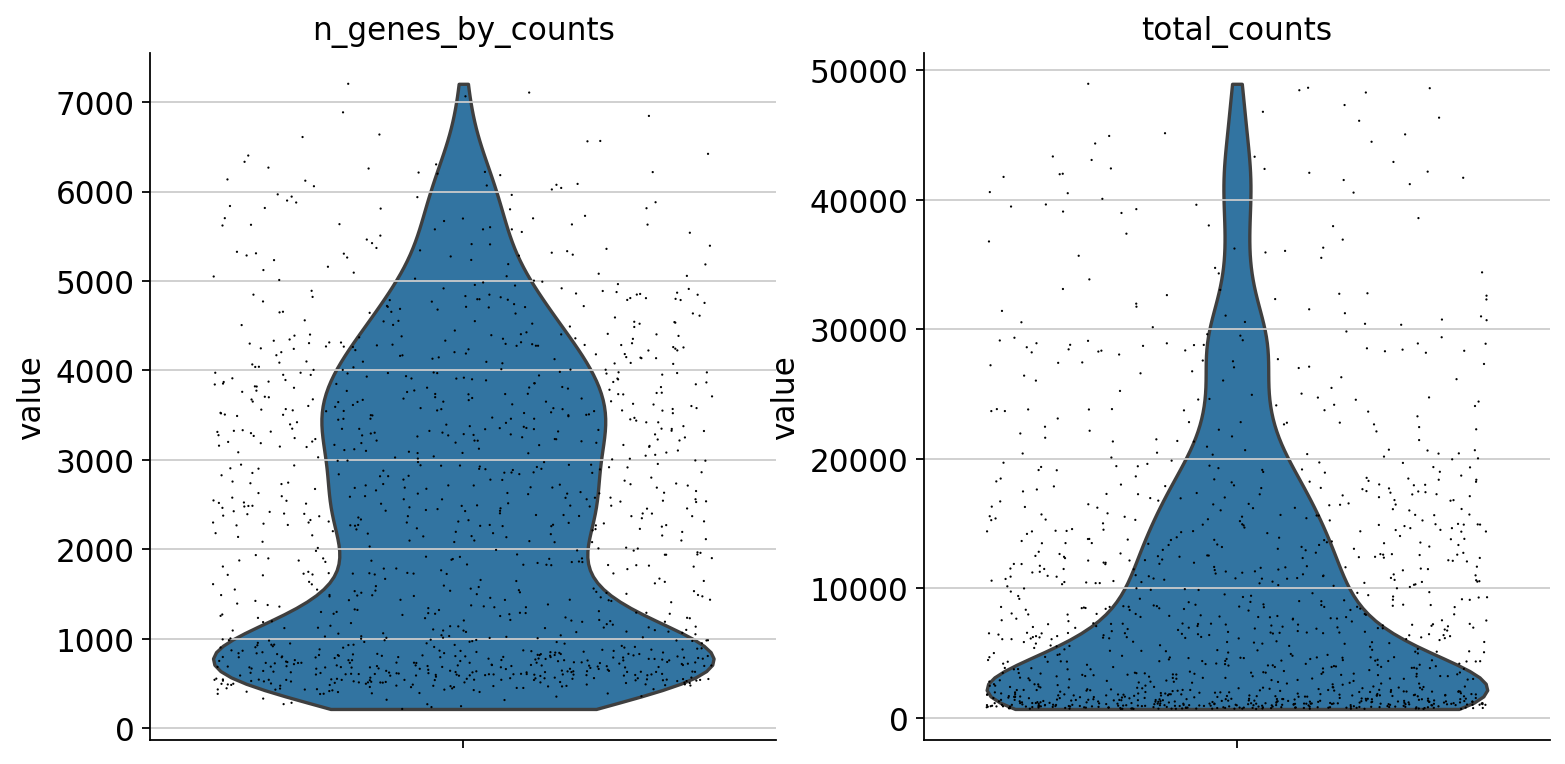

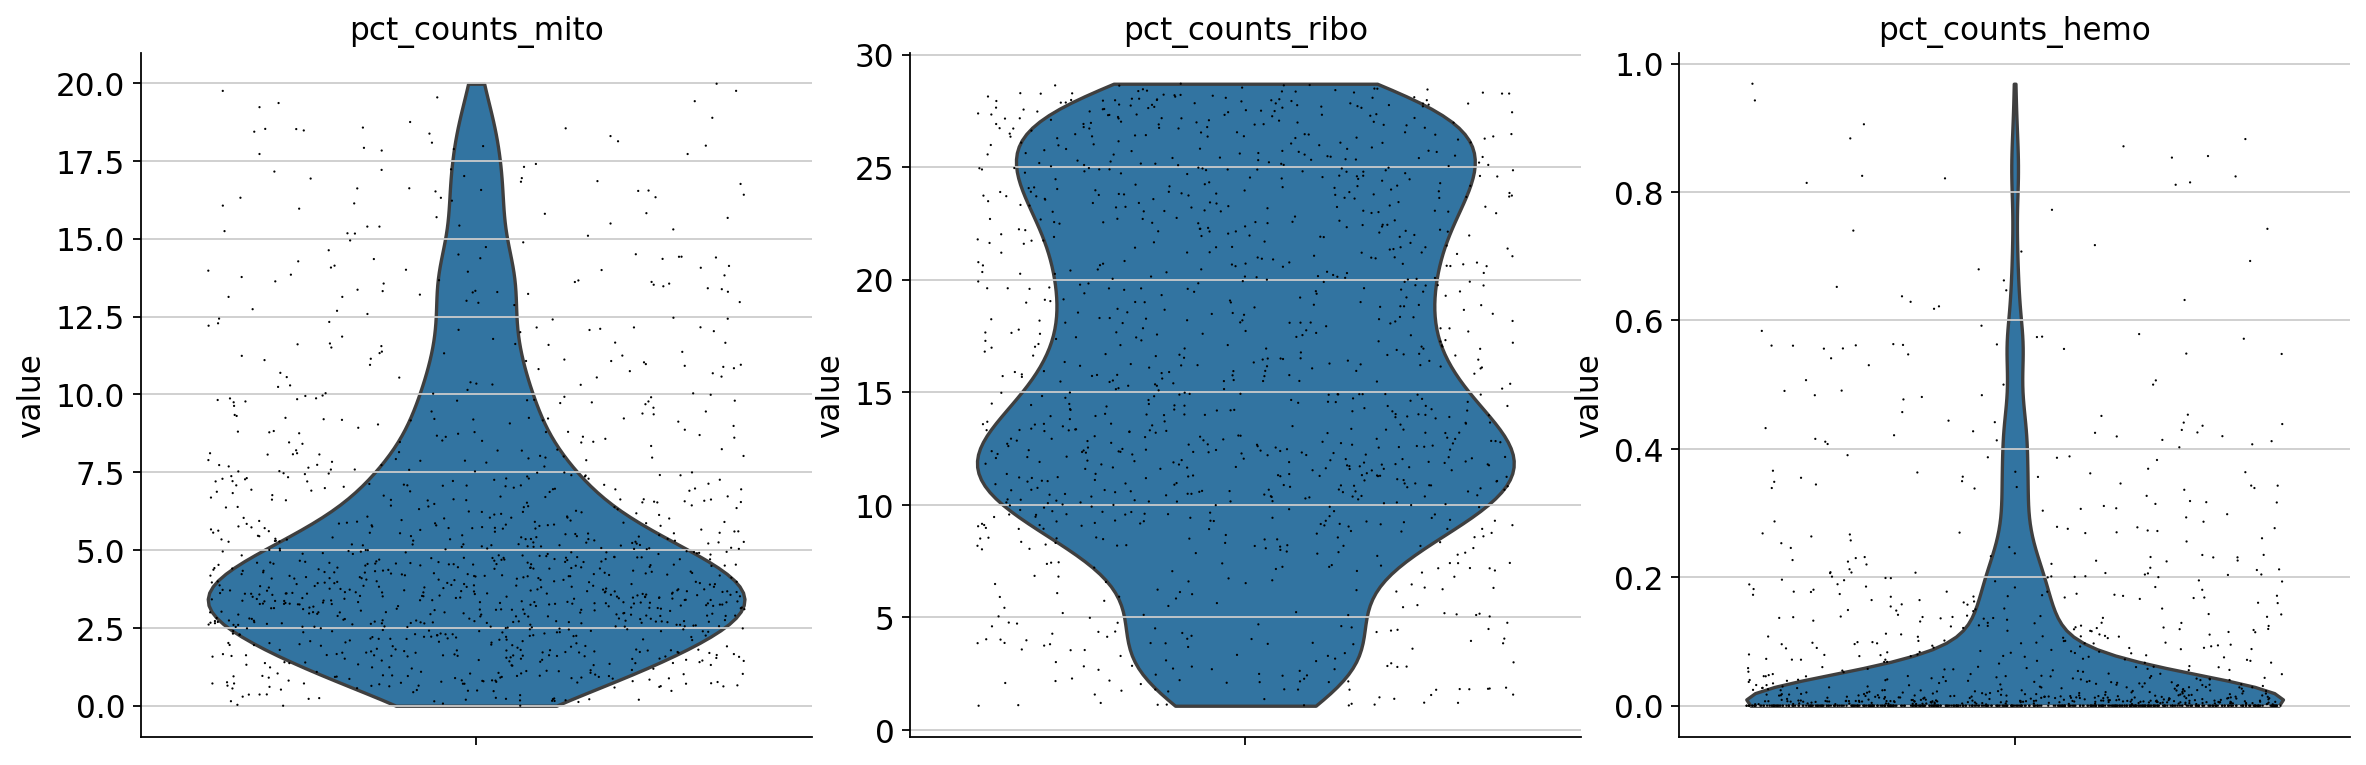

In [21]:
sc.pl.violin(Epi_GP28, ['n_genes_by_counts', 'total_counts'],
             jitter=0.4, multi_panel=True)
sc.pl.violin(Epi_GP28, ['pct_counts_mito', 'pct_counts_ribo', 'pct_counts_hemo'],
             jitter=0.4, multi_panel=True)

## Run normalization and logarithmize data

In [26]:
sc.pp.normalize_total(Epi_GP28, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


In [27]:
sc.pp.log1p(Epi_GP28)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


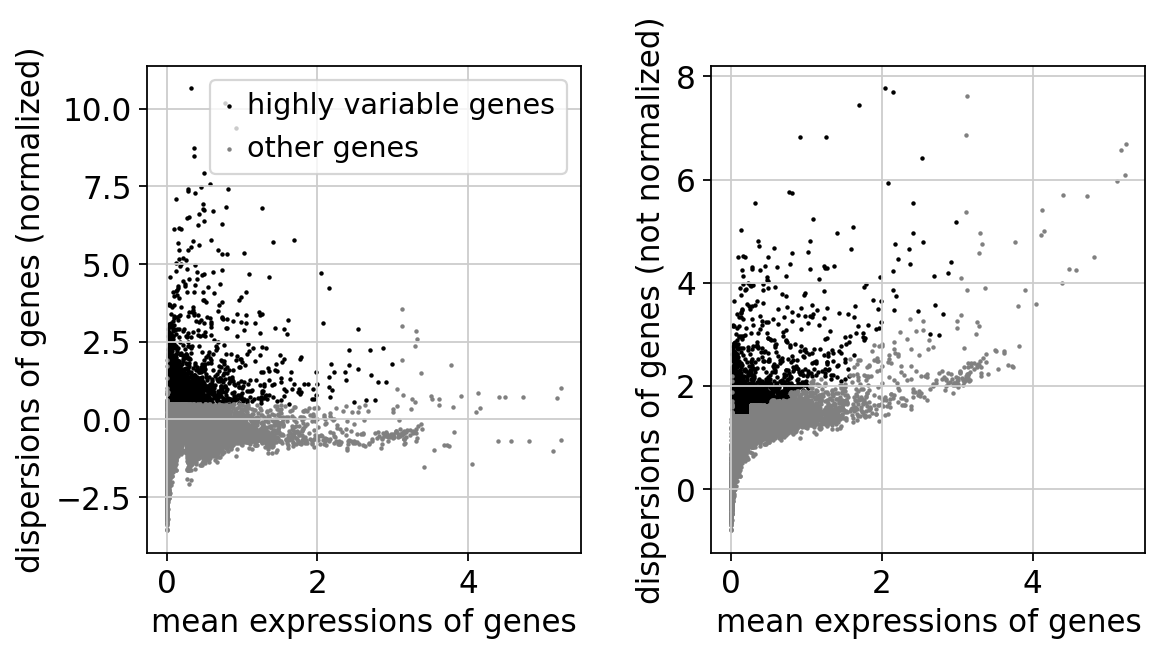

In [28]:
sc.pp.highly_variable_genes(Epi_GP28, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(Epi_GP28)

In [29]:
Epi_GP28.raw = Epi_GP28

## Calculate cell cycle scores

In [7]:
#First read the file with cell cycle genes, from Regev lab and split into S and G2M phase genes. Cell cycle genes were retrieved from the scanpy_usage github site via web browser at RegevLab Github repo.

cell_cycle_genes = [x.strip() for x in open("regev_lab_cell_cycle_genes.txt")]
print(len(cell_cycle_genes))

#Here we define two lists, genes associated to the S phase and genes associated to the G2M phase
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x.strip().title() for x in cell_cycle_genes if x.strip().title() in Epi_GP28.var_names]

print(len(cell_cycle_genes))

97
79


In [31]:
s_genes = [x.strip().title() for x in s_genes if x.strip().title() in Epi_GP28.var_names]
print(len(s_genes))
g2m_genes= [x.strip().title() for x in g2m_genes if x.strip().title() in Epi_GP28.var_names]
print(len(g2m_genes))

38
41


In [32]:
sc.tl.score_genes_cell_cycle(Epi_GP28, s_genes=s_genes, g2m_genes=g2m_genes, random_state=0)

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    644 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    607 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)


/home/diisakura/miniconda3/envs/oralfbs/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/home/diisakura/miniconda3/envs/oralfbs/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


computing PCA
    on highly variable genes
    with n_comps=31
    finished (0:00:00)


/home/diisakura/miniconda3/envs/oralfbs/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'phase' as categorical


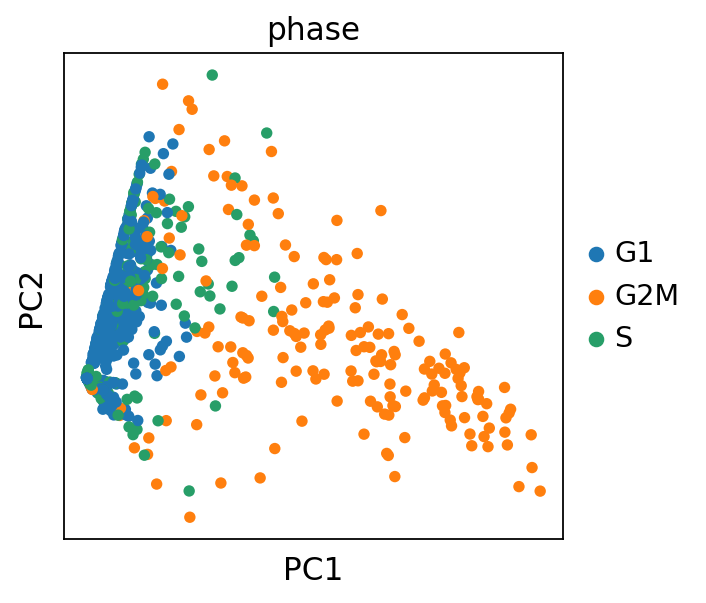

In [33]:
Epi_GP28_cc_genes = Epi_GP28[:, cell_cycle_genes]
sc.tl.pca(Epi_GP28_cc_genes)
sc.pl.pca_scatter(Epi_GP28_cc_genes, color='phase')

## Regressing out and scaling data

In [4]:
sc.pp.regress_out(Epi_GP28, ['n_genes_by_counts', 'pct_counts_mito'])
sc.pp.regress_out(Epi_GP28, ['pct_counts_ribo'])
sc.pp.regress_out(Epi_GP28, ['S_score', 'G2M_score'])
sc.pp.scale(Epi_GP28)

regressing out ['n_genes_by_counts', 'pct_counts_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:24)
regressing out ['pct_counts_ribo']
    finished (0:00:20)
regressing out ['S_score', 'G2M_score']
    finished (0:00:20)


In [6]:
Epi_GP28.obs

,n_genes,n_counts,n_genes_by_counts,total_counts,total_counts_mito,pct_counts_mito,total_counts_hemo,pct_counts_hemo,total_counts_ribo,pct_counts_ribo,S_score,G2M_score,phase
ACATCCCGTCCGACGT-1,6903,49008.0,6845,48958.0,1581.0,3.229298,0.0,0.000000,11237.0,22.952328,0.008074,1.188662,G2M
TACATTCGTTGGAGGT-1,5385,48475.0,5369,48461.0,2493.0,5.144343,0.0,0.000000,10767.0,22.217865,-0.047629,-0.125472,G1
AGATGAATCATACAGC-1,7137,48676.0,7106,48652.0,1901.0,3.907342,0.0,0.000000,10829.0,22.258078,0.441675,0.723791,G2M
GGTAATCTCCTCTCGA-1,6147,48638.0,6121,48617.0,2143.0,4.407923,0.0,0.000000,5714.0,11.753091,-0.053046,-0.216620,G1
AACAAAGAGAGAGCCT-1,6122,48318.0,6085,48285.0,2142.0,4.436160,1.0,0.002071,5827.0,12.067929,-0.064960,-0.203571,G1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
GATGCTACAAGGTTGG-1,515,717.0,512,715.0,43.0,6.013986,0.0,0.000000,15.0,2.097902,-0.043671,-0.119722,G1
AGTGCCGAGCTAGTTC-1,666,843.0,665,843.0,38.0,4.507710,0.0,0.000000,21.0,2.491103,-0.080341,-0.153743,G1
TCAGCCTTCCGACATA-1,487,734.0,484,733.0,28.0,3.819918,2.0,0.272851,8.0,1.091405,-0.042698,-0.110022,G1
CCCATTGTCGAGAACG-1,546,711.0,542,710.0,29.0,4.084507,0.0,0.000000,20.0,2.816901,-0.070492,0.067740,G2M


computing PCA
    on highly variable genes
    with n_comps=31
    finished (0:00:00)


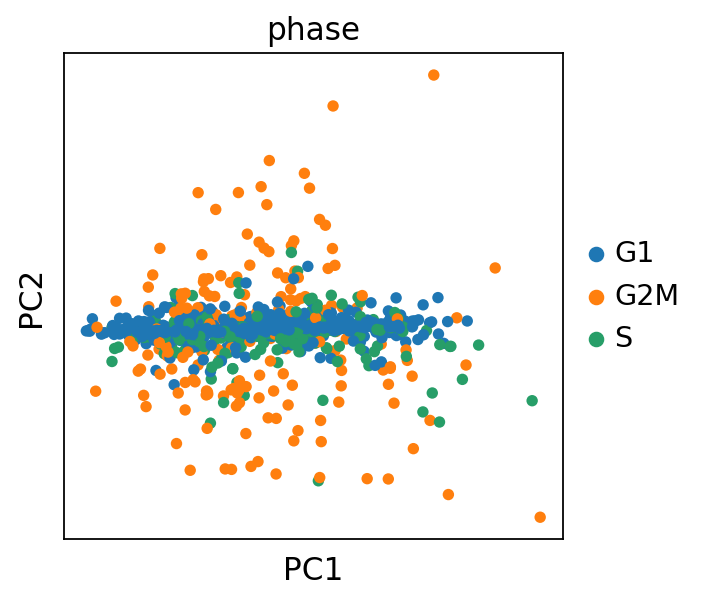

In [8]:
Epi_GP28_cc_genes = Epi_GP28[:, cell_cycle_genes]
sc.tl.pca(Epi_GP28_cc_genes)
sc.pl.pca_scatter(Epi_GP28_cc_genes, color='phase')

In [4]:
Epi_GP28 = Epi_GP28[:, Epi_GP28.var.highly_variable]

# Principal Component Analysis

In [5]:
sc.tl.pca(Epi_GP28, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


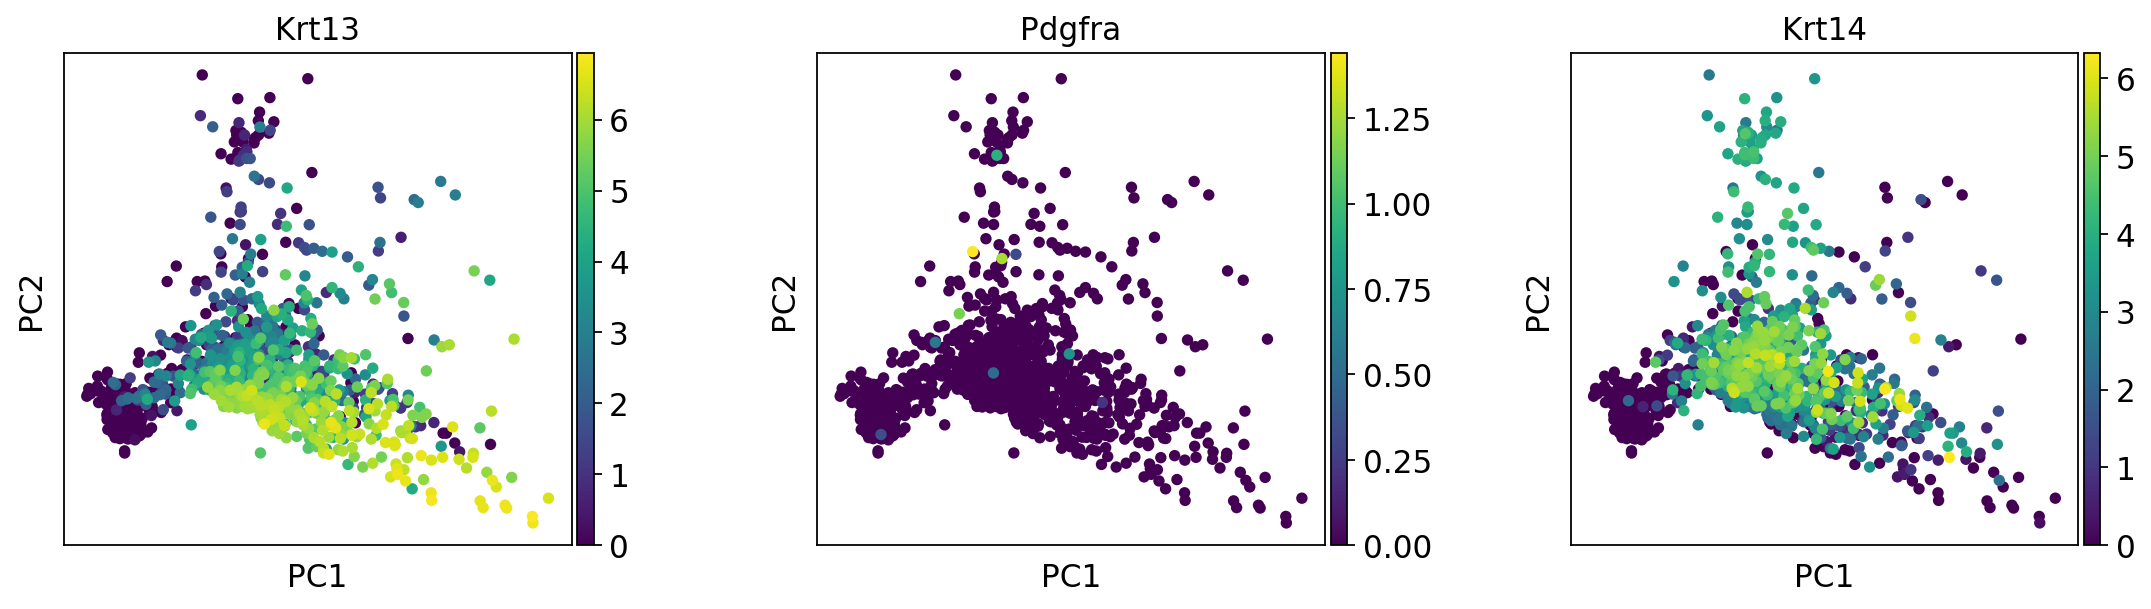

In [6]:
sc.pl.pca(Epi_GP28, color=['Krt13', 'Pdgfra', 'Krt14'], wspace=0.35)

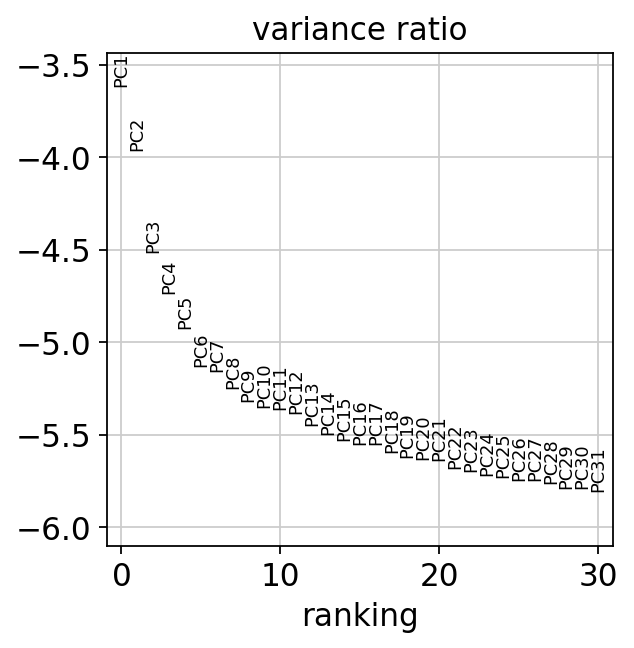

In [7]:
sc.pl.pca_variance_ratio(Epi_GP28, log=True)

In [8]:
Epi_GP28

AnnData object with n_obs × n_vars = 1140 × 3400
    obs: 'n_genes', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'total_counts_hemo', 'pct_counts_hemo', 'total_counts_ribo', 'pct_counts_ribo', 'S_score', 'G2M_score', 'phase'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'n_counts', 'mito', 'hemo', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

# Clustering the neighborhood graph

In [9]:
sc.pp.neighbors(Epi_GP28, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)


In [10]:
sc.tl.umap(Epi_GP28)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)


In [14]:
sc.tl.louvain(Epi_GP28, resolution=0.5)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 9 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


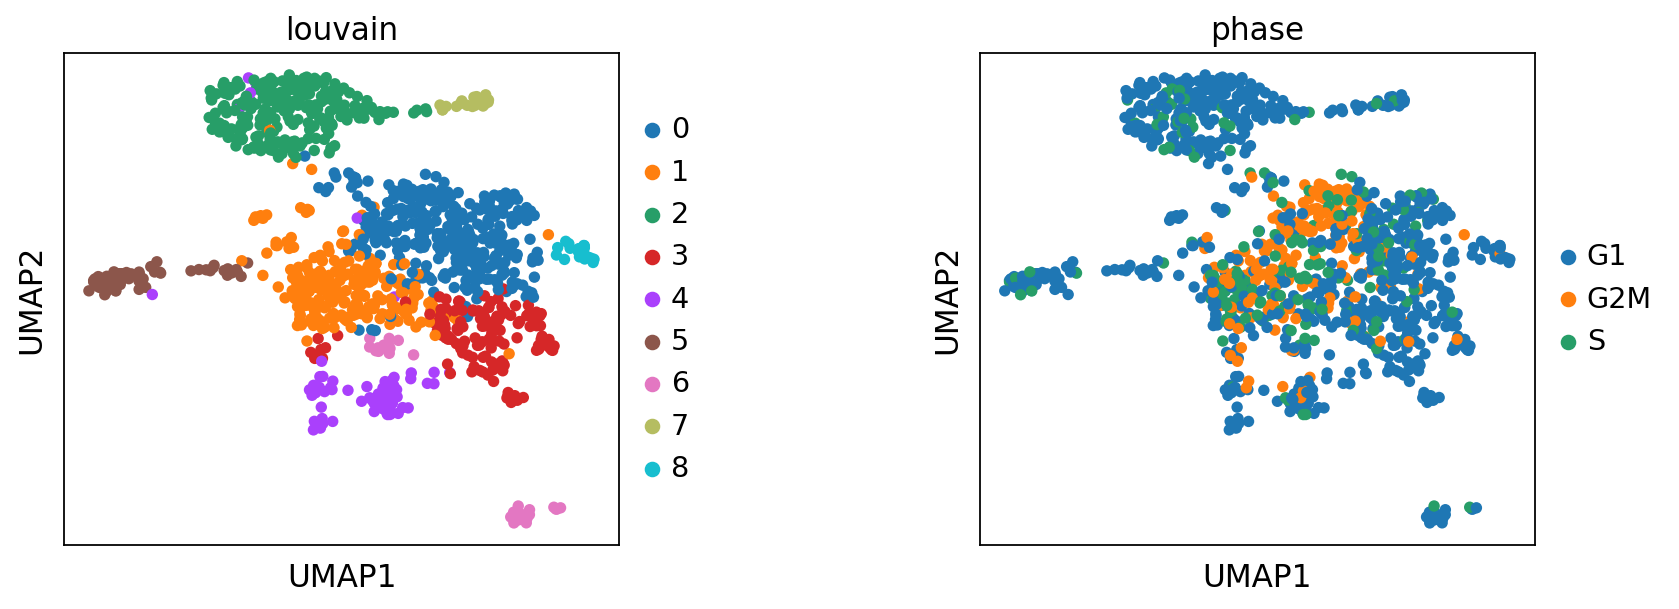

In [6]:
sc.pl.umap(Epi_GP28, color=['louvain','phase'], wspace=0.5)

# Plot UMAPs and Dotplot for Extended Data 4

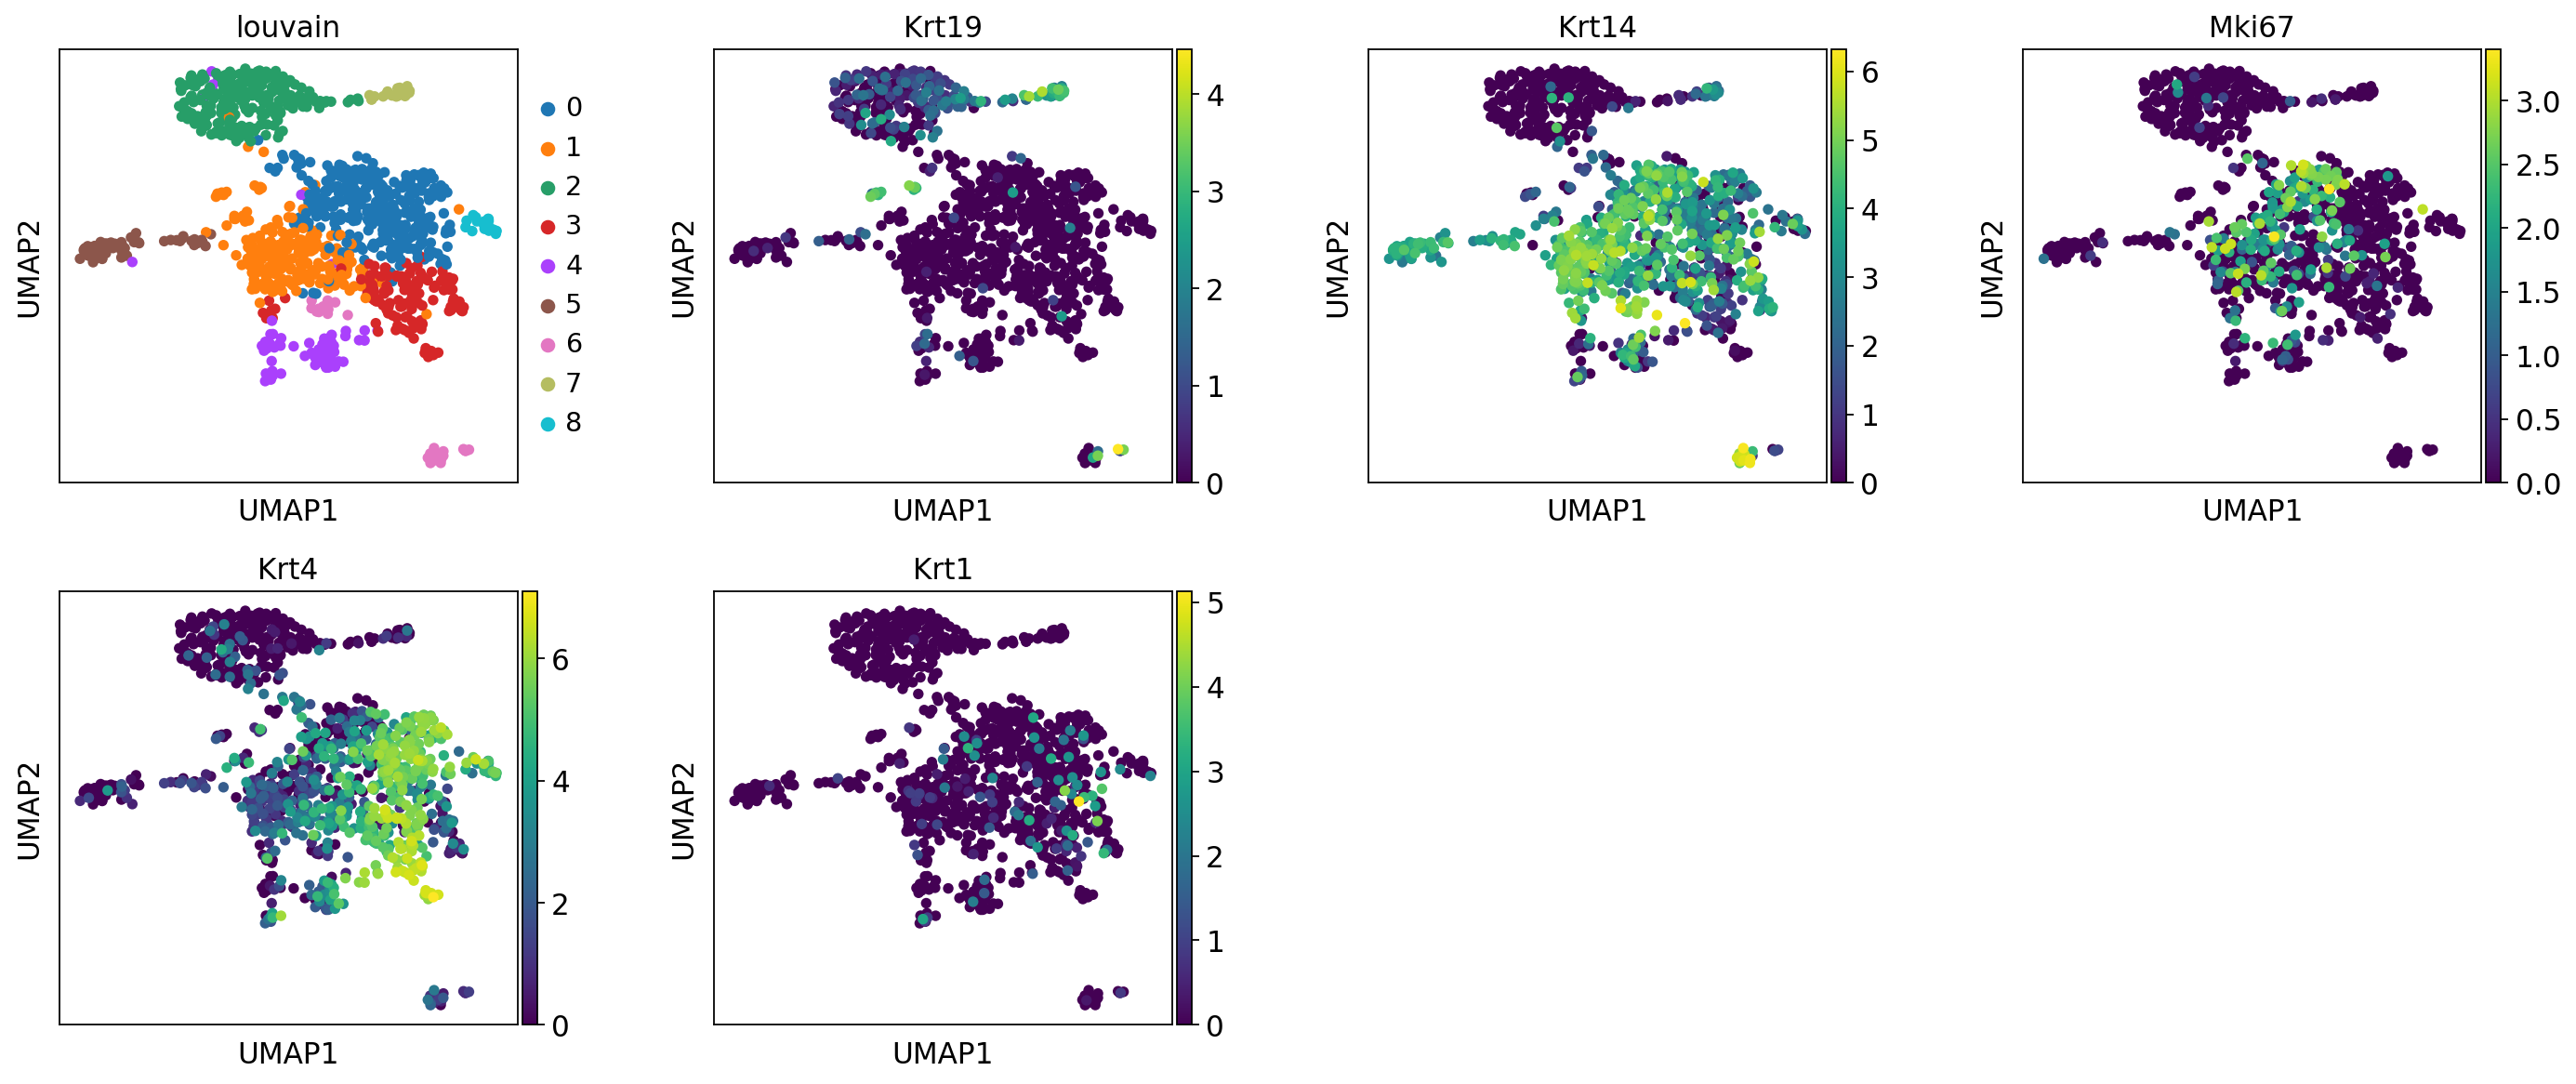

In [5]:
sc.pl.umap(Epi_GP28, color=['louvain','Krt19','Krt14','Mki67','Krt4','Krt1'], use_raw=True, wspace = 0.3)

In [18]:
sc.tl.dendrogram(Epi_GP28, groupby='louvain')

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_louvain']`


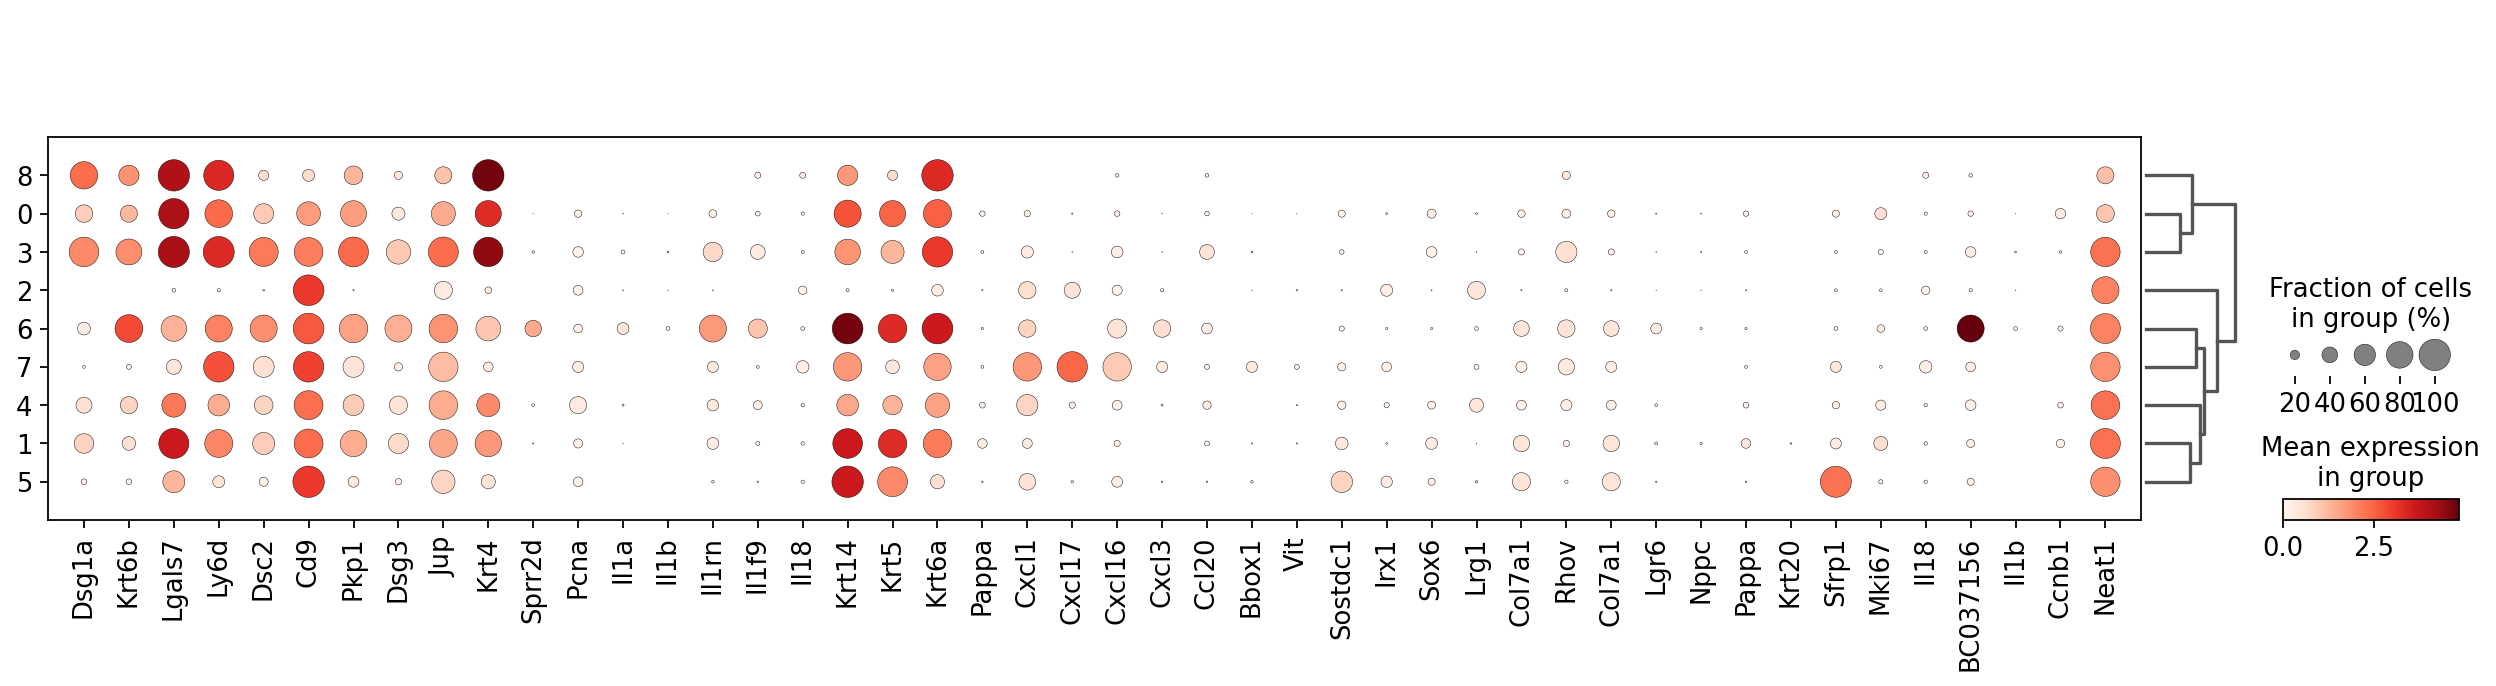

In [4]:
marker_genes4 = ['Dsg1a','Krt6b','Lgals7','Ly6d','Dsc2','Cd9','Pkp1','Dsg3','Jup','Krt4','Sprr2d','Pcna','Il1a','Il1b','Il1rn','Il1f9','Il18','Krt14','Krt5','Krt6a','Pappa','Cxcl1','Cxcl17','Cxcl16','Cxcl3','Ccl20','Bbox1','Vit','Sostdc1','Irx1','Sox6','Lrg1','Col7a1','Rhov','Col7a1','Lgr6','Nppc','Pappa','Krt20','Sfrp1','Mki67','Il18','BC037156','Il1b','Ccnb1','Neat1']
sc.pl.dotplot(Epi_GP28, marker_genes4, groupby='louvain', dendrogram=True)